# Housing Prices Competition - XGBRegressor

## Import required modules and libraries

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor

## Upload data

In [2]:
#Links to csv files
trainPath = r'C:\Users\TE435942\Jupyter_Notebook_Repository\Kaggle\Housing Market Analysis\train.csv'
testPath =  r'C:\Users\TE435942\Jupyter_Notebook_Repository\Kaggle\Housing Market Analysis\test.csv'

# Read the data
X = pd.read_csv(trainPath, index_col='Id')
X_test_full = pd.read_csv(testPath, index_col='Id')

# Remove rows with missing target, separate target from predictors
X.dropna(axis=0, subset=['SalePrice'], inplace=True)
y = X.SalePrice              
X.drop(['SalePrice'], axis=1, inplace=True)

# Break off validation set from training data
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                                random_state=0)

# "Cardinality" means the number of unique values in a column
# Select categorical columns with relatively low cardinality (convenient but arbitrary)
low_cardinality_cols = [cname for cname in X_train_full.columns if X_train_full[cname].nunique() < 10 and 
                        X_train_full[cname].dtype == "object"]

# Select numeric columns
numeric_cols = [cname for cname in X_train_full.columns if X_train_full[cname].dtype in ['int64', 'float64']]

# Keep selected columns only
my_cols = low_cardinality_cols + numeric_cols
X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()
X_test = X_test_full[my_cols].copy()

# Preprocessing for numerical data - SimpleImputer(mean) fills NaN values with mean of respective column.
numerical_transformer = SimpleImputer(strategy='mean')

# Preprocessing for categorical data - SimpleImputer fills NaN values with string 'NA'. OneHotEncoder encodes cat data.
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value = 'NA')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numeric_cols),
        ('cat', categorical_transformer, low_cardinality_cols)
    ])

In [3]:
model = XGBRegressor(random_state = 0, n_estimators = 775, learning_rate = 0.01)

## Now we will create a function to evaluate the efficacy of the model with different hyperparameters.

In [4]:
def getScore(n_estimators,learning_rate,early_stopping_rounds):
    
    model = XGBRegressor(random_state = 0, n_estimators = n_estimators, learning_rate = learning_rate)
    XGpipeline = Pipeline(steps=[('preprocessor', preprocessor),
                          ('model', model)
                         ])

    # Make a copy to avoid changing original data
    X_valid_eval=X_valid.copy()
    # Remove the model from pipeline
    eval_set_pipe = Pipeline(steps = [('preprocessor', preprocessor)])
    # fit transform X_valid.copy()
    X_valid_eval = eval_set_pipe.fit(X_train, y_train).transform (X_valid_eval)


    XGpipeline.fit(X_train, y_train, model__early_stopping_rounds=early_stopping_rounds, model__eval_metric = "mae", model__eval_set=[(X_valid_eval, y_valid)], model__verbose = False)

    preds = XGpipeline.predict(X_valid)

    mae = mean_absolute_error(preds,y_valid)
    
    return mae

## Evaluate for hyperparameters - this is just a very rough initial exploration into these parameters.

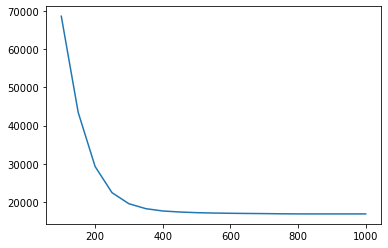

16836.128130351026
16836.128130351026


In [10]:
scores = {x:getScore(x,0.01,15) for x in list(range(100,1001,50))}
          
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(list(scores.keys()), list(scores.values()))
plt.show()
print(scores[900])
print(scores[1000])

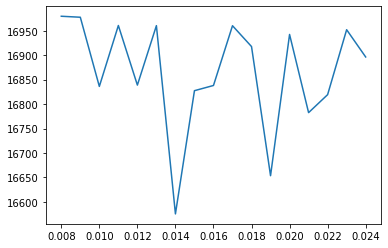

In [29]:
scores = {x:getScore(850,x,15) for x in [0.008,0.009,0.010, 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017, 0.018, 0.019, 0.020, 0.021, 0.022, 0.023, 0.024]}

import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(list(scores.keys()), list(scores.values()))
plt.show()

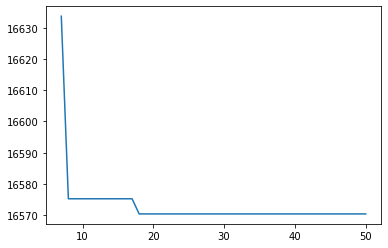

In [32]:
scores = {x:getScore(850,0.014,x) for x in [7,8,9,10,11,12,13,14,15,16,17,18,19,20,25,30,40,50]}

import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(list(scores.keys()), list(scores.values()))
plt.show()

In [33]:
model = XGBRegressor(random_state = 0, n_estimators = 850, learning_rate = 0.014)
XGpipeline = Pipeline(steps=[('preprocessor', preprocessor),
                          ('model', model)
                         ])

# Make a copy to avoid changing original data
X_valid_eval=X_valid.copy()
# Remove the model from pipeline
eval_set_pipe = Pipeline(steps = [('preprocessor', preprocessor)])
# fit transform X_valid.copy()
X_valid_eval = eval_set_pipe.fit(X_train, y_train).transform (X_valid_eval)


XGpipeline.fit(X_train, y_train, model__early_stopping_rounds=20, model__eval_metric = "mae", model__eval_set=[(X_valid_eval, y_valid)], model__verbose = False)
preds_test = XGpipeline.predict(X_test)

output = pd.DataFrame({'Id': X_test.index,
                       'SalePrice': preds_test})
output.to_csv('submission.csv', index=False)

In [60]:
XGpipeline.steps[1][1].get_label()

AttributeError: 'XGBRegressor' object has no attribute 'get_label'